# Annual mean basal melt pattern and integrated mass loss compared against observations and other models
## WAOM10

In [1]:
# load roms history output as Xarray dataset
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"eta_max,xi_max = find_etaxi(lat_max,lon_max,grd)
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)

from features.rotate_vector_roms import rotate_vector_roms
from visualization.shiftedColorMap import shiftedColorMap

In [2]:
file_path = os.path.join(os.environ.get('rawdir'),'hre10_nudg','ocean_avg_0008.nc')
ds = xr.open_dataset(file_path,chunks={'eta_rho':100,'xi_rho':100})
grid_path = os.path.join(os.environ.get('rawdir'),'gdata','hr_exp','waom10_stable_grd.nc')
grd = xr.open_dataset(grid_path)

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<IPython.core.display.Javascript object>


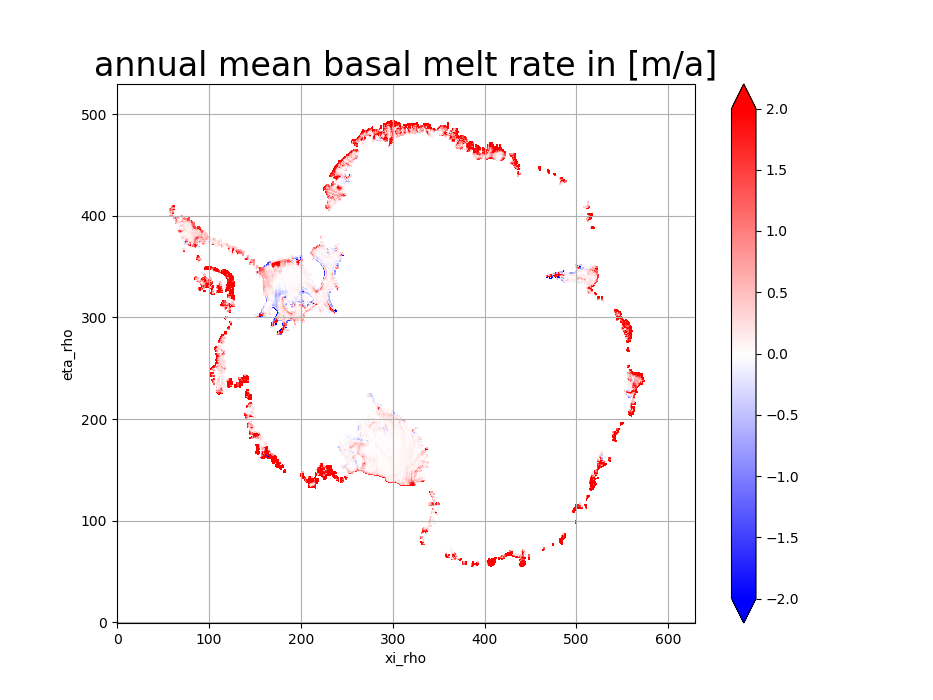

In [15]:
%matplotlib notebook

m_min=-2
m_max=2
m_cmap = shiftedColorMap(plt.cm.bwr,midpoint= (1 - m_max/(m_max + abs(m_min))))

s2a = 3600*24*365

ism = (grd.zice < 0.0)&(grd.mask_rho==1)
ism.values[200:300,400:500] = False

plt.close()
(ds.m.where(ism).mean('ocean_time')*s2a).plot(vmin=-2,vmax=2,size=7,cmap=m_cmap)
plt.title('annual mean basal melt rate in [m/a]',fontsize=24)
#plt.axis('off')
plt.grid()
plt.show()

In [4]:
dA = (1/(grd.pm*grd.pn)).where(ism)
weights = dA/dA.sum()

m_avg = (ds.m.where(ism).mean('ocean_time')*weights*s2a).sum()
print('Area average melt rate in m/yr: ',m_avg.values)

rho0 = 1025
rho0onrhoi = 1025/917

bmb = ds.m.where(ism).mean('ocean_time')*dA*rho0*rho0onrhoi*(10**-12)*s2a
print('Basal mass loss in Gt/a: ',bmb.sum().values)


/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Area average melt rate in m/yr:  0.917462234512523
Basal mass loss in Gt/a:  1765.6569103095649


## Individual ice shelves

In [146]:
# Titles and figure names for each ice shelf
names = ['Larsen D Ice Shelf', 'Larsen C Ice Shelf','Wilkins Ice Shelf', 'Stange Ice Shelf', 'George VI Ice Shelf (1)' , 'George VI Ice Shelf (2)','Ronne-Filchner Ice Shelf', 'Abbot Ice Shelf', 'Pine Island Glacier Ice Shelf', 'Thwaites Ice Shelf', 'Dotson Ice Shelf', 'Getz Ice Shelf', 'Nickerson Ice Shelf', 'Sulzberger Ice Shelf', 'Mertz Ice Shelf', 'Totten & Moscow University Ice Shelves', 'Shackleton Ice Shelf', 'West Ice Shelf', 'Amery Ice Shelf', 'Prince Harald Ice Shelf', 'Baudouin & Borchgrevink Ice Shelves', 'Lazarev Ice Shelf', 'Nivl Ice Shelf', 'Fimbul & Jelbart & Ekstrom Ice Shelves', 'Brunt & Riiser-Larsen Ice Shelves', 'Ross Ice Shelf']
# Limits on longitude and latitude for each ice shelf
# These depend on the source geometry, in this case RTopo 1.05
# Note there is one extra index at the end of each array; this is because
# the Ross region crosses the line 180W and therefore is split into two
lon_min = [ -62.67, -65.5,-75, -79, -74.5, -69.5, -85, -104.17, -102.5, -108.33, -114.5, -135.67, -149.17, -155, 144, 115, 94.17, 80.83, 65, 33.83, 19, 12.9, 9.33, -10.05, -28.33, 158.33]
lon_max = [ -59.33, -60,-69, -74.5, -67, -66, -28.33, -88.83, -99.17, -103.33, -111.5, -114.33, -140, -145, 146.62, 123.33, 102.5, 89.17, 75, 37.67, 33.33, 16.17, 12.88, 7.6, -10.33, -146.67]
lat_min = [ -73.03, -69.35,-71.5, -73.8, -73.8, -72.6, -83.5, -73.28, -75.5, -75.5, -75.33, -74.9, -76.42, -78, -67.83, -67.17, -66.67, -67.83, -73.67, -69.83, -71.67, -70.5, -70.75, -71.83, -76.33, -84.5]
lat_max = [ -69.37, -66.13,-69, -72.6, -72.6, -70, -74.67, -71.67, -74.17, -74.67, -73.67, -73, -75.17, -76.41, -66.67, -66.5, -64.83, -66.17, -68.33, -68.67, -68.33, -69.33, -69.83, -69.33, -71.5, -77.77]
# Observed mass loss (Rignot 2013) and uncertainty for each ice shelf, in Gt/y
obs_massloss = [ 1.4, 20.7, 135.4, 155.4, 51.8, 101.2, 97.5, 45.2, 144.9, 4.2, 18.2, 7.9, 90.6, 72.6, 27.2, 35.5, -2, 21.6, 6.3, 3.9, 26.8, 9.7, 47.7]
obs_massloss_error = [ 14, 67, 40, 45, 19, 8, 7, 4, 14, 2, 3, 3, 8, 15, 10, 23, 3, 18, 2, 2, 14, 16, 34]
# Observed ice shelf melt rates and uncertainty
obs_ismr = [ 0.1, 0.4, 3.1, 0.3, 1.7, 16.2, 17.7, 7.8, 4.3, 0.6, 1.5, 1.4, 7.7, 2.8, 1.7, 0.6, -0.4, 0.4, 0.7, 0.5, 0.5, 0.1, 0.1]
obs_ismr_error = [ 0.6, 1, 0.8, 0.1, 0.6, 1, 1, 0.6, 0.4, 0.3, 0.3, 0.6, 0.7, 0.6, 0.7, 0.4, 0.6, 0.4, 0.2, 0.2, 0.2, 0.2, 0.1]
# Density of ice in kg/m^3
rho_ice = 916


In [147]:
from scipy.spatial import KDTree
#find eta/xi values based on grid and lat/lon combo
def find_etaxi(lat,lon,grd):

    lat_flat = grd.lat_rho.stack(etaxi = ('eta_rho','xi_rho'))
    lon_flat = grd.lon_rho.stack(etaxi = ('eta_rho','xi_rho'))

    points = np.column_stack((lat_flat.values,lon_flat.values))
    tree = KDTree(points)

    target = np.column_stack((lat,lon))
    dist, ind = tree.query(target)

    eta = lat_flat[ind].eta_rho.values
    xi = lat_flat[ind].xi_rho.values

    return eta,xi

eta_min,xi_min = find_etaxi(lat_min,lon_min,grd)
eta_max,xi_max = find_etaxi(lat_max,lon_max,grd)

ii = xi_max<xi_min
tmp = xi_max[ii]
xi_max[ii]=xi_min[ii]
xi_min[ii]=tmp

ii = eta_max<eta_min
tmp = eta_max[ii]
eta_max[ii]=eta_min[ii]
eta_min[ii]=tmp

<IPython.core.display.Javascript object>


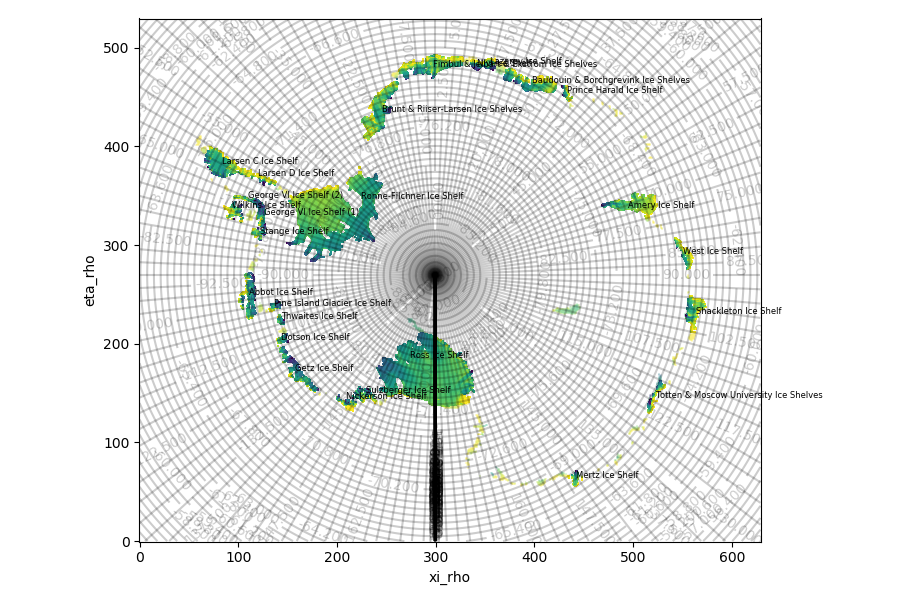

In [148]:
%matplotlib notebook
from matplotlib.patches import Rectangle

plt.close()
fig,ax = plt.subplots(figsize=(9,6))
grd.zice.where((grd.mask_rho==1)&(grd.zice<0)).plot(ax=ax,alpha=0.2,add_colorbar=False)
for lomi,loma,lami,lama,emi,xmi,ema,xma,name in zip(lon_min,lon_max,lat_min,lat_max,eta_min,xi_min,eta_max,xi_max,names):
    if lomi<loma:
        mask_shelf = (grd.mask_rho==1) & (grd.zice<0) & \
        (grd.lon_rho>lomi) & (grd.lon_rho<=loma) & (grd.lat_rho>lami) & (grd.lat_rho<=lama)
    else:
        mask_shelf = (grd.mask_rho==1) & (grd.zice<0) &\
        ((grd.lon_rho>lomi) | (grd.lon_rho<=loma)) & (grd.lat_rho>lami) & (grd.lat_rho<=lama)
        
    #ax.add_patch(Rectangle((xmi,emi), xma-xmi, ema-emi, fill=False,color="r"))
                
    grd.zice.where(mask_shelf).plot(ax=ax,add_colorbar=False)
    ax.text(xmi+0.5*(xma-xmi),emi+0.5*(ema-emi),name,fontsize=6)
    
latp = grd.lat_rho.plot.contour(alpha=0.2,levels=65,add_colorbar=False,colors="k")
plt.clabel(latp,inline=1)
lonp = grd.lon_rho.plot.contour(alpha=0.2,levels=180,add_colorbar=False,colors="k")
plt.clabel(lonp,inline=1)

ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [149]:
m_tmp = []
bmb_tmp = []
dA_tmp =[]

for lomi,loma,lami,lama in zip(lon_min,lon_max,lat_min,lat_max):
    if lomi<loma:
        mask_shelf = (grd.mask_rho==1) & (grd.zice<0) & \
        (grd.lon_rho>lomi) & (grd.lon_rho<=loma) & (grd.lat_rho>lami) & (grd.lat_rho<=lama)
    else:
        mask_shelf = (grd.mask_rho==1) & (grd.zice<0) &\
        ((grd.lon_rho>lomi) | (grd.lon_rho<=loma)) & (grd.lat_rho>lami) & (grd.lat_rho<=lama)
        
    dA = (1/(grd.pm*grd.pn)).where(mask_shelf)
    weights = dA/dA.sum()
    
    dA_tmp.append(float(dA.sum().values))

    m_tmp.append(float((ds.m.where(mask_shelf).mean('ocean_time')*weights*s2a).sum().values))
    bmb_tmp.append(float((ds.m.where(mask_shelf).mean('ocean_time')*dA*rho0*rho0onrhoi*(10**-12)*s2a).sum().values))
    
m_tmp[4]=(m_tmp[4]*dA_tmp[4]+m_tmp[5]*dA_tmp[5])/(dA_tmp[4]+dA_tmp[5])
m_tmp[5:-1] = m_tmp[6:]
m = m_tmp[:-1]

bmb_tmp[4] = bmb_tmp[4]+bmb_tmp[5]
bmb_tmp[5:-1] = bmb_tmp[6:]
bmb = bmb_tmp[:-1]

dA_tmp[4] = dA_tmp[4]+dA_tmp[5]
dA_tmp[5:-1] = dA_tmp[6:]
dA = dA_tmp[:-1]

names[4] = "George VI Ice Shelf"
names[5:-1] = names[6:]
names = names[:-1]

import pandas as pd
df = pd.DataFrame.from_dict({'names':names,'m_avg':m,'bmb':bmb,'A':dA})
df

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStic

,A,bmb,m_avg,names
0,1.638056e+10,9.847007,0.524683,Larsen D Ice Shelf
1,5.742416e+10,31.322386,0.476082,Larsen C Ice Shelf
2,1.582555e+10,32.811599,1.809632,Wilkins Ice Shelf
3,8.731802e+09,12.676874,1.267155,Stange Ice Shelf
4,2.378536e+10,146.371296,5.371157,George VI Ice Shelf
5,4.389104e+11,73.386579,0.145936,Ronne-Filchner Ice Shelf
6,3.503566e+10,35.959876,0.895838,Abbot Ice Shelf
7,6.981975e+09,45.838160,5.730209,Pine Island Glacier Ice Shelf
8,4.557317e+09,17.400376,3.332507,Thwaites Ice Shelf
9,6.266449e+09,5.288589,0.736614,Dotson Ice Shelf


## Rignot et al. 2013 observations and Schodlock 2016 model
Rignot et al. (2013) use the volume flux divergence of ice shelves in Antarctica, the surface mass balance (from regional atmospheric climate models), and the rate of ice shelf thickening (from laser altimetry) to determine melt rate and mass balance for the period 2003–2009 (top figure below).
They estimate the total basal mass loss as 1325 ± 235 Gt/a.

Schodlock et al. (2016) incorporates an explicit representation of ice‐shelf‐ocean interaction in the Estimating the Circulation and Climate of the Ocean, Phase II (ECCO2) ocean model configuration (bottom figure below).
They estimate the total basal mass loss as 1735 ± 164 Gt/a.


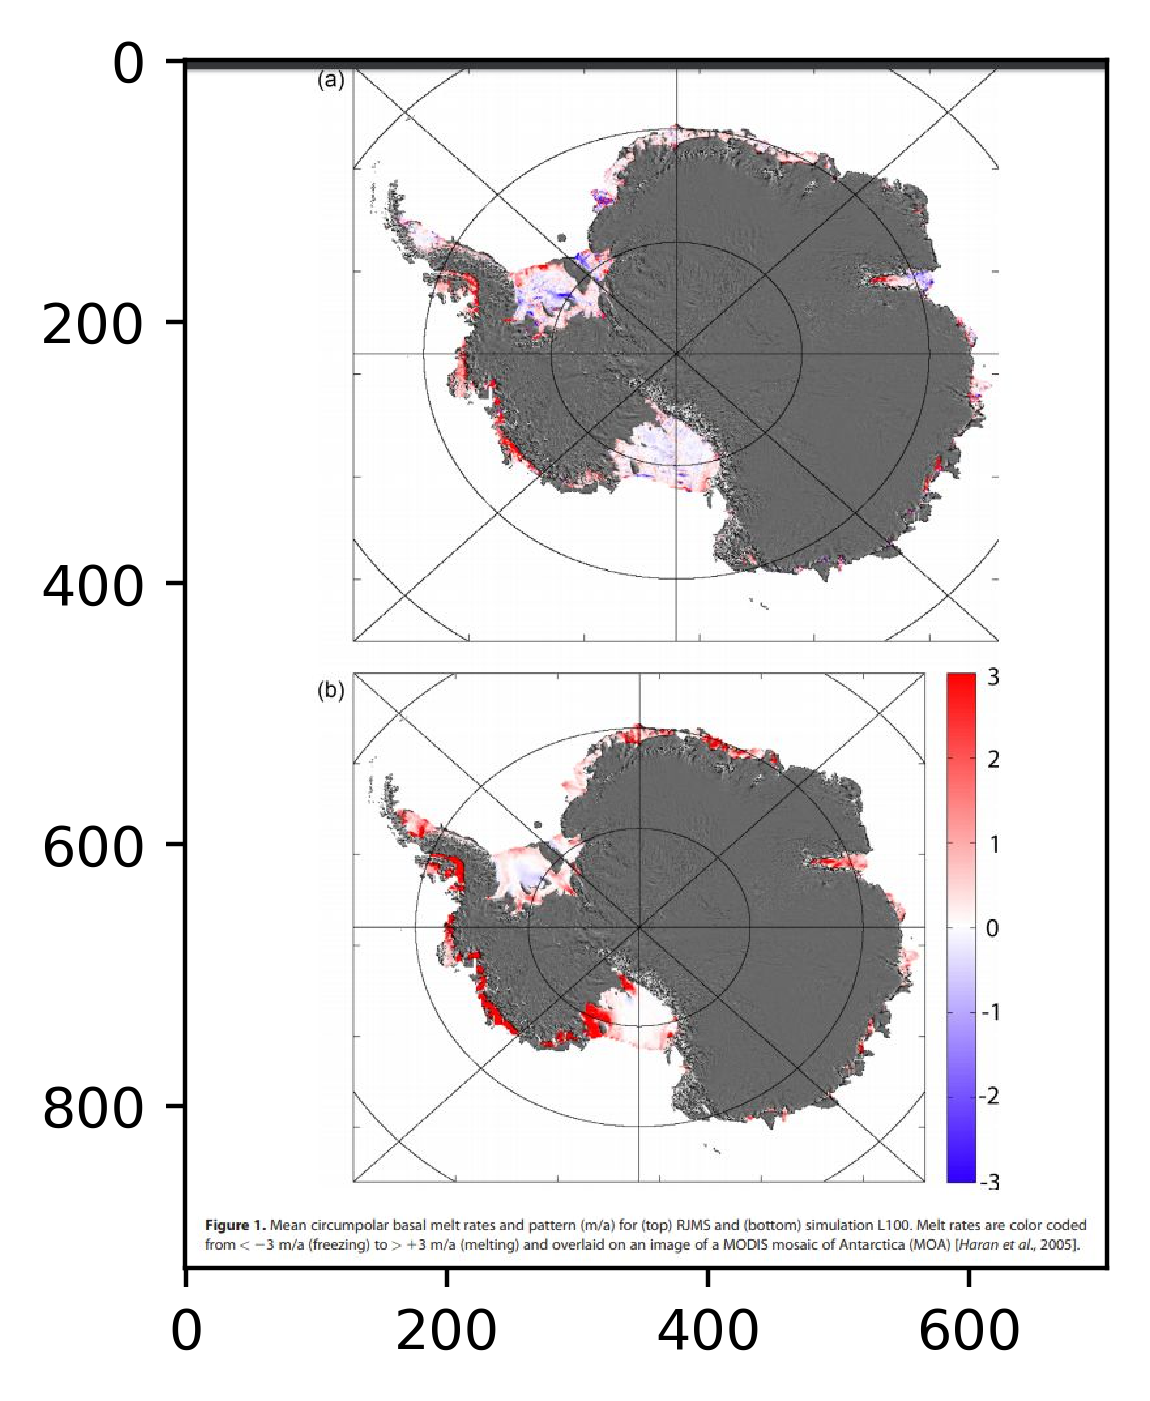

In [14]:
filename = '../../reports/figures/bm_schodlok.png'
image = plt.imread(filename)

plt.close()
plt.figure(dpi=400)
plt.imshow(image)

## Melting derived using sattelite data
### Deporter et al. 2012
Deporter 2012 use satellite measurements of calving flux and grounding-line flux, modelled ice-shelf snow accumulation rates and a regional scaling that accounts for unsurveyed areas. They obtain a total basal mass balance of 1,454 ± 174 gigatonnes per year.

### Liu et al. 2013
Liu 2015 use the Interferometric Synthetic Aperture Radar (InSAR) velocities and ice thicknesses at the flux gates to calculate cross-grounding line flux. Ice thicknesses are estimated by combining MCORDS data and ICESat GLAS data.
We use the surface mass balance product derived from a firn model.
Iceberg calving is the actual rate of ice mass loss due to iceberg calving rather than a “flux gate” calculation (2, 3). It is calculated as the product of the mean ice thickness of the area loss due to calving and area of annual calving losses (SI Materials and Methods).
They estimate the total basal mass balance as 1516 ± 106 Gt/y.

### Adusumilli (private comn.)
Susheel Adusumilli (private communications) uses CryoSat-2 data to estimate melting.
After interpolation to our grid, we estimate total mass loss as 392 Gt/a.

In [7]:
susheel_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_nudge_wb.nc')
satelite = xr.open_dataset(susheel_path)

In [9]:
satelite['wb'] = satelite.wb*(24*3600*365)

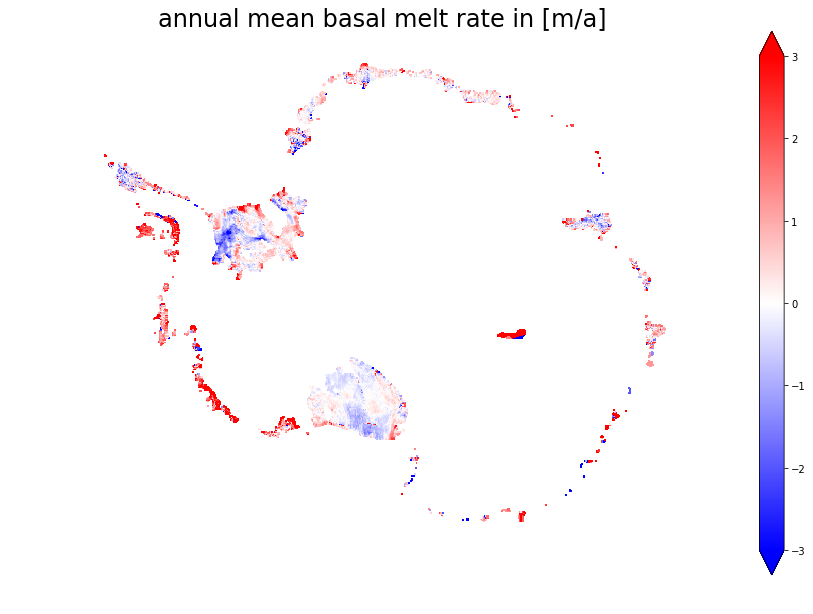

In [11]:
%matplotlib inline
plt.close()
satelite.wb.where((grd.zice < 0.0)&(grd.mask_rho==1)).mean('sst_time').plot(cmap=plt.cm.bwr,size=10,vmin=-3,vmax=3)
plt.title('annual mean basal melt rate in [m/a]',fontsize=24)
plt.axis('off')
plt.show()

In [12]:
bmb_sat = satelite.wb.mean('sst_time').where((grd.zice < 0.0)&(grd.mask_rho==1))*dA*rho0*rho0onrhoi*(10**-12)
print('Basal mass loss in Gt/a: ',bmb_sat.sum().values)

Basal mass loss in Gt/a:  392.0015657493118


## Other models
### Timmerman et al. 2012
Timmerman et al includes an ice shelf component into Finite Element Sea ice Ocean Model (FESOM) and estimayes an total basal mass balance of about 1600 Gt/a.

### Naughten et al. 2018
Naughten et al 2018 compares melting calculated from MetRoms (Regional Ocean Modelling System (ROMS) coupled to Community Ice CodE (CICE)) and the global model Finite Element Sea-ice
Ocean Model (FESOM). The latter has been tested for high and low resolution.
MetROMS, low res FESOM and high res FESOM estimate the total basal mass loss over 2002–
2016 as, respectively, 642 Gt/a, 586 Gt/a and 739 Gt/a.